# Analysis

Michelle Flesaker  
2026-01-20

## Overview

This document creates tables and figures for the manuscript.

## Setup

In [ ]:
#| label: setup
#| message: false

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

here() starts at /Users/michelleflesaker/Documents/PhD/reproducible-workflow-workshop

## Load Cleaned Data

In [ ]:
#| label: load-data

# Load cleaned data from data-cleaning.qmd
data_clean <- readRDS(here("results", "data_clean.rds"))

## The repetitive approach

In [ ]:
#| label: repetitive-regression
#| eval: false

library(broom)  # tidy() function to convert model output to data frame

# Model for blood pressure
model_bp <- data_clean |>
  lm(BPSysAve ~ Education + Age + Gender, data = _)

# tidy() converts model output to a clean data frame with columns:
#   term, estimate, std.error, statistic, p.value, conf.low, conf.high
# str_detect() finds rows where "term" contains "Education"
tidy(model_bp, conf.int = TRUE) |>
  filter(str_detect(term, "Education"))

# Model for BMI (copy-paste and change outcome variable...)
model_bmi <- data_clean |>
  lm(BMI ~ Education + Age + Gender, data = _)

tidy(model_bmi, conf.int = TRUE) |>
  filter(str_detect(term, "Education"))

## Building the regression function

In [ ]:
#| label: define-regression-function

# Function to run education model for any outcome
fit_education_model <- function(data, outcome_var) {
  
  # as.formula() + paste() creates formula from string
  # e.g., "BPSysAve" becomes: BPSysAve ~ Education + Age + Gender
  formula <- as.formula(paste(outcome_var, "~ Education + Age + Gender"))

  data |>
    lm(formula, data = _) |>
    # tidy() converts lm output to a data frame
    tidy(conf.int = TRUE) |>
    # Keep only Education-related coefficients
    filter(str_detect(term, "Education")) |>
    # Add column to track which outcome this is
    mutate(outcome = outcome_var)
}

## Using the regression function (one at a time)

In [ ]:
#| label: use-regression-function

# Now the analysis is simple and clear
data_clean |> fit_education_model("BPSysAve")

# A tibble: 4 × 8
  term           estimate std.error statistic p.value conf.low conf.high outcome
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl> <chr>  
1 Education9 - …   -0.704     0.919    -0.766 4.44e-1    -2.50      1.10 BPSysA…
2 EducationHigh…   -0.252     0.857    -0.294 7.69e-1    -1.93      1.43 BPSysA…
3 EducationSome…   -0.490     0.828    -0.592 5.54e-1    -2.11      1.13 BPSysA…
4 EducationColl…   -3.91      0.830    -4.71  2.48e-6    -5.54     -2.28 BPSysA…

# A tibble: 4 × 8
  term           estimate std.error statistic p.value conf.low conf.high outcome
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl> <chr>  
1 Education9 - …  -0.388      0.397   -0.977  3.28e-1   -1.17      0.390 BMI    
2 EducationHigh…  -0.0118     0.370   -0.0319 9.75e-1   -0.737     0.713 BMI    
3 EducationSome…  -0.281      0.357   -0.785  4.32e-1   -0.981     0.420 BMI    
4 EducationColl…  -1.89       0.358   -5.27   1.40e-7   -2.59     -1.19  BMI    

## Using map() to iterate the regression function

In [ ]:
#| label: use-map

outcomes <- c("BPSysAve", "BMI")

# map() runs the function for each element in outcomes
# \(y) is shorthand for function(y) - an "anonymous function"
# list_rbind() stacks the results into one data frame
results <- map(outcomes, \(y) data_clean |> fit_education_model(y)) |>
  list_rbind()

results

# A tibble: 8 × 8
  term           estimate std.error statistic p.value conf.low conf.high outcome
  <chr>             <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl> <chr>  
1 Education9 - …  -0.704      0.919   -0.766  4.44e-1   -2.50      1.10  BPSysA…
2 EducationHigh…  -0.252      0.857   -0.294  7.69e-1   -1.93      1.43  BPSysA…
3 EducationSome…  -0.490      0.828   -0.592  5.54e-1   -2.11      1.13  BPSysA…
4 EducationColl…  -3.91       0.830   -4.71   2.48e-6   -5.54     -2.28  BPSysA…
5 Education9 - …  -0.388      0.397   -0.977  3.28e-1   -1.17      0.390 BMI    
6 EducationHigh…  -0.0118     0.370   -0.0319 9.75e-1   -0.737     0.713 BMI    
7 EducationSome…  -0.281      0.357   -0.785  4.32e-1   -0.981     0.420 BMI    
8 EducationColl…  -1.89       0.358   -5.27   1.40e-7   -2.59     -1.19  BMI    

## Subgroup analysis

In [ ]:
#| label: subgroup-function

# Function to run model within each level of a grouping variable
fit_model_by_group <- function(data, group_var) {
  data |>
    # nest_by() splits data by group, storing each subset in a "data" column
    # e.g., for Gender: one row for "male" with all male data,
    #                   one row for "female" with all female data
    nest_by({{ group_var }}) |>
    # reframe() runs the model on each group's data and returns multiple rows
    # (summarize() expects 1 row per group; reframe() allows many)
    reframe(
      tidy(lm(BPSysAve ~ Education + Age, data = data), conf.int = TRUE)
    ) |>
    # Keep only the College Grad coefficient (vs 8th Grade reference)
    filter(term == "EducationCollege Grad")
}

## Use with different grouping variables

In [ ]:
#| label: use-subgroup-function

# Stratify by Gender
data_clean |> fit_model_by_group(Gender)

# A tibble: 2 × 8
  Gender term            estimate std.error statistic p.value conf.low conf.high
  <fct>  <chr>              <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
1 female EducationColle…    -2.99      1.20     -2.49 1.29e-2    -5.34    -0.634
2 male   EducationColle…    -4.74      1.13     -4.20 2.76e-5    -6.96    -2.53 

# A tibble: 5 × 8
  Race1    term          estimate std.error statistic p.value conf.low conf.high
  <fct>    <chr>            <dbl>     <dbl>     <dbl>   <dbl>    <dbl>     <dbl>
1 Black    EducationCol…    -1.74      3.99    -0.437  0.662     -9.58    6.09  
2 Hispanic EducationCol…    -1.67      2.68    -0.621  0.535     -6.95    3.61  
3 Mexican  EducationCol…    -5.26      2.39    -2.20   0.0283    -9.96   -0.560 
4 White    EducationCol…    -2.87      1.43    -2.00   0.0453    -5.67   -0.0602
5 Other    EducationCol…    -5.80      2.62    -2.22   0.0269   -10.9    -0.665 

## Table 1: Participant Characteristics

In [ ]:
#| label: tbl-demographics
#| tbl-cap: "Participant characteristics by education level"

data_clean |>
  mutate(Gender = str_to_title(Gender)) |>
  select(Education, Age, Gender, Race1, BPSysAve) |>
  tbl_summary(
    by = Education,
    statistic = list(
      all_continuous() ~ "{mean} ({sd})",
      all_categorical() ~ "{n} ({p}%)"
    ),
    label = list(
      Age ~ "Age (years)",
      Gender ~ "Sex",
      Race1 ~ "Race/Ethnicity",
      BPSysAve ~ "Systolic BP (mmHg)"
    ),
    missing = "no"
  ) |>
  add_overall() |>
  bold_labels()

Characteristic,"Overall N = 6,9081",8th Grade N = 4171,9 - 11th Grade N = 8581,"High School N = 1,4461","Some College N = 2,1611","College Grad N = 2,0261"
Age (years),47 (17),55 (18),48 (18),47 (18),45 (17),47 (15)
Sex,,,,,,
Female,"3,494 (51%)",190 (46%),382 (45%),729 (50%),"1,135 (53%)","1,058 (52%)"
Male,"3,414 (49%)",227 (54%),476 (55%),717 (50%),"1,026 (47%)",968 (48%)
Race/Ethnicity,,,,,,
Black,768 (11%),21 (5.0%),148 (17%),208 (14%),266 (12%),125 (6.2%)
Hispanic,395 (5.7%),63 (15%),65 (7.6%),83 (5.7%),110 (5.1%),74 (3.7%)
Mexican,577 (8.4%),165 (40%),134 (16%),119 (8.2%),109 (5.0%),50 (2.5%)
White,"4,658 (67%)",128 (31%),473 (55%),985 (68%),"1,509 (70%)","1,563 (77%)"
Other,510 (7.4%),40 (9.6%),38 (4.4%),51 (3.5%),167 (7.7%),214 (11%)


## Fit the linear regression model

In [ ]:
# Model: Blood pressure ~ Education + covariates
model_fit <- lm(BPSysAve ~ Education + Gender + Race1, data = data_clean)

# View the results
summary(model_fit)


Call:
lm(formula = BPSysAve ~ Education + Gender + Race1, data = data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.951 -11.278  -2.604   8.396 110.305 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             129.1542     1.0772 119.901  < 2e-16 ***
Education9 - 11th Grade  -5.8758     1.0238  -5.739 9.92e-09 ***
EducationHigh School     -6.1876     0.9717  -6.368 2.04e-10 ***
EducationSome College    -7.3347     0.9438  -7.772 8.87e-15 ***
EducationCollege Grad    -9.9932     0.9563 -10.450  < 2e-16 ***
Gendermale                3.7973     0.4042   9.394  < 2e-16 ***
Race1Hispanic            -6.1250     1.0446  -5.864 4.74e-09 ***
Race1Mexican             -8.0645     0.9541  -8.452  < 2e-16 ***
Race1White               -2.0127     0.6588  -3.055  0.00226 ** 
Race1Other               -5.7781     0.9685  -5.966 2.55e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 16.76

## Figure 1: Main Result (Box Plot)

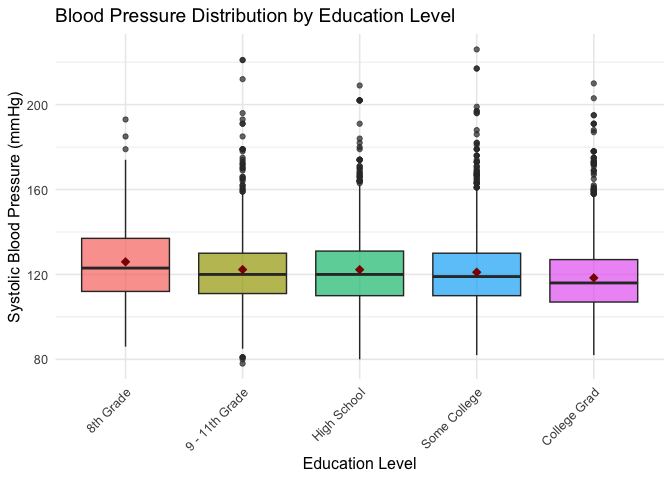

In [ ]:
#| label: fig-bp-education
#| fig-cap: "Distribution of systolic BP by education level"
#| fig-width: 7
#| fig-height: 5

data_clean |>
  ggplot(aes(x = Education, y = BPSysAve, fill = Education)) +
  geom_boxplot(alpha = 0.7) +
  stat_summary(
    fun = mean,
    geom = "point",
    shape = 18,
    size = 3,
    color = "darkred"
  ) +
  labs(
    x = "Education Level",
    y = "Systolic Blood Pressure (mmHg)",
    title = "Blood Pressure Distribution by Education Level"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "none",
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

As shown in `@tbl-demographics`, participants varied by education level.

Blood pressure distribution is visualized in `@fig-bp-education`.

## Table 2: Main Analysis

In [ ]:
#| label: tbl-main
#| tbl-cap: "Association between education level and systolic blood pressure"

model_fit |>
  tbl_regression(
    label = list(
      Education ~ "Education level",
      Gender ~ "Sex",
      Race1 ~ "Race/ethnicity"
    )
  ) |>
  bold_labels()

Characteristic,Beta,95% CI,p-value
Education level,,,
8th Grade,—,—,
9 - 11th Grade,-5.9,"-7.9, -3.9",<0.001
High School,-6.2,"-8.1, -4.3",<0.001
Some College,-7.3,"-9.2, -5.5",<0.001
College Grad,-10,"-12, -8.1",<0.001
Sex,,,
female,—,—,
male,3.8,"3.0, 4.6",<0.001
Race/ethnicity,,,


Results of the linear regression are shown in `@tbl-main`.

## Comparisons - Fit two models

In [ ]:
#| label: fit-two-models

# Model 1: Without age adjustment
model_crude <- lm(BPSysAve ~ Education + Gender + Race1, data = data_clean)

# Model 2: With age adjustment
model_adjusted <- lm(BPSysAve ~ Education + Gender + Race1 + Age, data = data_clean)

## Extract and compare coefficients

In [ ]:
#| label: compare-models

# Extract College Grad coefficient from both models
crude_result <- model_crude |>
  tidy(conf.int = TRUE) |>
  filter(term == "EducationCollege Grad") |>
  mutate(model = "Crude (no age)")

adjusted_result <- model_adjusted |>
  tidy(conf.int = TRUE) |>
  filter(term == "EducationCollege Grad") |>
  mutate(model = "Age-adjusted")

# Combine into comparison table
comparison <- bind_rows(crude_result, adjusted_result) |>
  select(model, estimate, conf.low, conf.high, p.value)

comparison

# A tibble: 2 × 5
  model          estimate conf.low conf.high  p.value
  <chr>             <dbl>    <dbl>     <dbl>    <dbl>
1 Crude (no age)    -9.99   -11.9      -8.12 2.27e-25
2 Age-adjusted      -4.09    -5.83     -2.36 3.94e- 6

## Visualize the comparison

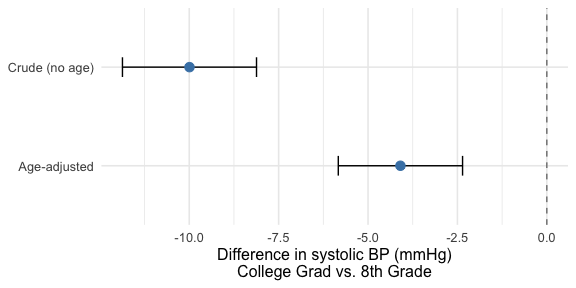

In [ ]:
#| label: fig-comparison
#| fig-cap: "Comparison of crude and age-adjusted estimates for College Grad vs 8th Grade"
#| fig-width: 6
#| fig-height: 3

comparison |>
  ggplot(aes(x = estimate, y = model)) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
  geom_point(size = 3, color = "steelblue") +
  labs(
    x = "Difference in systolic BP (mmHg)\nCollege Grad vs. 8th Grade",
    y = NULL
  ) +
  theme_minimal(base_size = 12)

## Create a publication-ready table

In [ ]:
#| label: tbl-comparison
#| tbl-cap: "Comparison of crude and age-adjusted estimates for education-BP association"

comparison |>
  gt() |>
  fmt_number(columns = c(estimate, conf.low, conf.high), decimals = 1) |>
  fmt_number(columns = p.value, decimals = 3) |>
  cols_merge(
    columns = c(conf.low, conf.high),
    pattern = "({1}, {2})"
  ) |>
  cols_label(
    model = "Model",
    estimate = "β",
    conf.low = "95% CI",
    p.value = "P-value"
  )

Model,β,95% CI,P-value
Crude (no age),−10.0,"(−11.9, −8.1)",0.000
Age-adjusted,−4.1,"(−5.8, −2.4)",0.000
